In [1]:
import torch
import torchvision
from torch.nn import functional as F

import os
import cv2
import numpy as np
from sklearn import metrics
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from model import CNN 
from dataset import DCADataset 
from loss_fn import cross_entropy_with_dca_loss as ce_dca_loss
import utilities as UT


In [2]:
def get_ece(logits, labels, n_bins = 15):
    softmaxes = F.softmax(logits, dim=1)
    confidences, predictions = torch.max(softmaxes, 1)
    accuracies = predictions.eq(labels)
    ece = torch.zeros(1, device=logits.device)

    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    bin_boundaries, bin_lowers, bin_uppers

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Calculated |confidence - accuracy| in each bin
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean() # weight of current bin            

        if prop_in_bin.item() > 0:        
            accuracy_in_bin = accuracies[in_bin].float().mean()
            avg_confidence_in_bin = confidences[in_bin].mean()    
            ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece


def get_mce(logits, labels, n_bins = 15):
    softmaxes = F.softmax(logits, dim=1)
    confidences, predictions = torch.max(softmaxes, 1)
    accuracies = predictions.eq(labels)
    mce = torch.zeros(1, device=logits.device)

    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    bin_boundaries, bin_lowers, bin_uppers

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Calculated |confidence - accuracy| in each bin
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()            

        if prop_in_bin.item() > 0:        
            accuracy_in_bin = accuracies[in_bin].float().mean()
            avg_confidence_in_bin = confidences[in_bin].mean()    
            error = torch.abs(avg_confidence_in_bin - accuracy_in_bin)
            if(error>mce):
                mce = error
                
    return mce

In [3]:
FEATURE = 'Alex'
DATASET = 'Mendeley'
PATH_TRAIN = './Mendeley_train_list.csv'
PATH_TEST = './Mendeley_test_list.csv'
LOSS_WEIGHTS = torch.tensor([0.735, 0.265]) 
NUM_OF_CLASS = 2

GPU = 3
EPOCHS = 10
LR=0.0001
BATCH_SIZE = 64
RESIZE = True
PRETRAINED = True
REQUIRES_GRAD = False
FEATURE_SHAPE=(256,25,25) 

BETA=25

device = torch.device('cuda:'+str(GPU) if torch.cuda.is_available() else 'cpu')

dataset = DCADataset(label_file=PATH_TRAIN, 
                     resize=RESIZE, 
                     augmentation=True)
dataloader = torch.utils.data.DataLoader(dataset, 
                                         num_workers=4, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=True, 
                                         drop_last=True)

val_dataset = DCADataset(label_file=PATH_TEST, 
                         resize=RESIZE, 
                         augmentation=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                             num_workers=4, 
                                             batch_size=BATCH_SIZE, 
                                             shuffle=False, 
                                             drop_last=True)


file_name: /data/scratch/gliang/data/lung_xray/Chest_X-Ray_Images_Pneumonia/train/PNEUMONIA/person294_bacteria_1385.jpeg


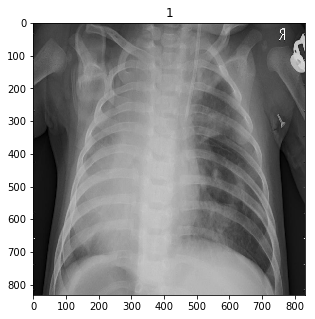

In [4]:
# show one random sample
dataiter = iter(dataloader)    
images, labels, full_path = dataiter.next()
UT.imshow(images, labels, full_path)

In [ ]:
# initiate the network
net = CNN(num_classes = NUM_OF_CLASS, 
          feature_shape=FEATURE_SHAPE, 
          feature=FEATURE, 
          pretrained=PRETRAINED, 
          requires_grad=REQUIRES_GRAD).float().to(device)
opt = torch.optim.Adam(net.parameters(), lr=LR, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma= 0.985)
loss_fcn = torch.nn.CrossEntropyLoss(weight=LOSS_WEIGHTS.to(device))

print(net)

CNN(
  (ft_ext): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv1): Sequential(
    (0): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running

In [ ]:
t = trange(EPOCHS, desc=' ', leave=True)

train_hist = []
test_hist = []
pred_result = []
old_acc = 0
for e in t:    
    y_true = []
    y_pred = []
    test_y_true = []
    test_y_pred = []

    # training
    net.train()
    for step, (img, label, _) in enumerate(dataloader):
        img = img.float().to(device)
        label = label.long().to(device)
        opt.zero_grad()
        out = net(img)
        loss = loss_fcn(out, label) # weighted cross-entropy
        y_true, y_pred = UT.assemble_labels(step, y_true, y_pred, label, out)
        loss.backward()
        opt.step()
        t.set_description("step: %i, loss: %.4f" %(step, loss.item()))
        
    acc = float(torch.sum(torch.max(y_pred, 1)[1]==y_true))/ float(len(y_pred))
    auc = metrics.roc_auc_score(y_true.cpu().detach().numpy(), y_pred.cpu().detach().numpy()[:,1])
    f1 = metrics.f1_score(y_true.cpu().detach().numpy(), torch.max(y_pred, 1)[1].cpu().detach().numpy())
    precision = metrics.precision_score(y_true.cpu().detach().numpy(), torch.max(y_pred, 1)[1].cpu().detach().numpy())
    recall = metrics.recall_score(y_true.cpu().detach().numpy(), torch.max(y_pred, 1)[1].cpu().detach().numpy())
    ap = metrics.average_precision_score(y_true.cpu().detach().numpy(), torch.max(y_pred, 1)[1].cpu().detach().numpy()) #average_precision
    ac = torch.mean(torch.max(F.softmax(y_pred, dim=1), 1)[0]) # average predict confidence        
    ece = get_ece(y_pred, y_true)
    mce = get_mce(y_pred, y_true)    
    
    scheduler.step()
    
    # testing
    net.eval()
    with torch.no_grad():
        for step, (img, label, _) in enumerate(val_dataloader):
            img = img.float().to(device)
            label = label.long().to(device)
            out = net(img)
            loss = loss_fcn(out, label)

            test_y_true, test_y_pred = UT.assemble_labels(step, test_y_true, test_y_pred, label, out)

    test_acc = float(torch.sum(torch.max(test_y_pred, 1)[1]==test_y_true))/ float(len(test_y_pred))
    test_auc = metrics.roc_auc_score(test_y_true.cpu().detach().numpy(), test_y_pred.cpu().detach().numpy()[:,1])
    test_f1 = metrics.f1_score(test_y_true.cpu().detach().numpy(), torch.max(test_y_pred, 1)[1].cpu().detach().numpy())
    test_precision = metrics.precision_score(test_y_true.cpu().detach().numpy(), torch.max(test_y_pred, 1)[1].cpu().detach().numpy())
    test_recall = metrics.recall_score(test_y_true.cpu().detach().numpy(), torch.max(test_y_pred, 1)[1].cpu().detach().numpy())
    test_ap = metrics.average_precision_score(test_y_true.cpu().detach().numpy(), torch.max(test_y_pred, 1)[1].cpu().detach().numpy()) #average_precision
    test_ac = torch.mean(torch.max(F.softmax(test_y_pred, dim=1), 1)[0]) # average predict confidence
    test_ece = get_ece(test_y_pred, test_y_true)
    test_mce = get_mce(test_y_pred, test_y_true)
            
    train_hist.append([loss.item(), acc, auc, f1, precision, recall, ap, ac.item(), ece.item(), mce.item()])        
    test_hist.append([test.item(), test_acc, test_auc, test_f1, test_precision, test_recall, test_ap, test_ac.item(), test_ece.item(), test_mce.item()])
   
    # save model and test result
    if(test_acc>old_acc):
        print('Epoch: %d\n  -Train Acc %.4f  -Train AC %.4f  - Train ECE %.4f  - Train MCE %.4f\n  -Val Acc   %.4f  -Val AC   %.4f  - Val ECE   %.4f  - Val MCE   %.4f' 
              %(e+1, acc, ac, ece, mce, test_acc, test_ac, test_ece, test_mce))
        old_acc = test_acc




step: 10, loss: 0.4931:   0%|          | 0/10 [00:26<?, ?it/s]